# Text Mining and Clustering Analysis
This notebook performs the following steps:
1. Load and preprocess the dataset.
2. Convert text data into a TF-IDF matrix.
3. Apply clustering and evaluate cluster quality.
4. Perform dimensionality reduction and re-cluster.
5. Conduct sentiment analysis and visualize results.
6. Generate word clusters and save results.

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram


## Step 1: Load the Dataset

In [3]:
with open('dataset.json', 'r') as file:
    data = pd.read_json(file)
print(data.head())


   timestamp                                               text     text_id  \
0 2024-10-31  Running a business means juggling countless ad...  2018569761   
1 2024-10-31  Liz Truss is walking in the lingering shadow o...  2092717718   
2 2024-10-31  The UK is bracing for war as government buildi...  2059143248   
3 2024-10-31  Marrying a second or third cousin once removed...  2008209828   
4 2024-10-31  It's truly disgraceful how the Indian National...  2001239278   

               user     user_id  
0     danielwoodard  1077866112  
1  nelsonjacqueline  1089670430  
2           ihooper  1007478642  
3    wrightnicholas  1039258480  
4         michael51  1021455936  


## Step 2: Preprocess Text Data

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join(stemmer.stem(word) for word in text.split() if word not in stop_words)
    return text

data['processed_text'] = data['text'].apply(preprocess_text)


## Step 3: Convert to TF-IDF Matrix

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_features=20000, max_df=0.95, min_df=2)  # Adjust parameters
tfidf_matrix = tfidf_vectorizer.fit_transform(data['processed_text'])
print(tfidf_matrix.shape)

(70260, 20000)


## Step 4: Apply Dimensionality Reduction (PCA)

In [13]:
# Reduce dimensions using Truncated SVD
n_components = 200  # Start with 100 components
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_tfidf = svd.fit_transform(tfidf_matrix)

print("Explained variance ratio sum:", svd.explained_variance_ratio_.sum())


Explained variance ratio sum: 0.22484941038219658


In [6]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
# Compute linkage matrix using cosine similarity
linkage_matrix = linkage(1 - cosine_sim, method='ward')  # Ward's method minimizes variance within clusters

## Chossing K

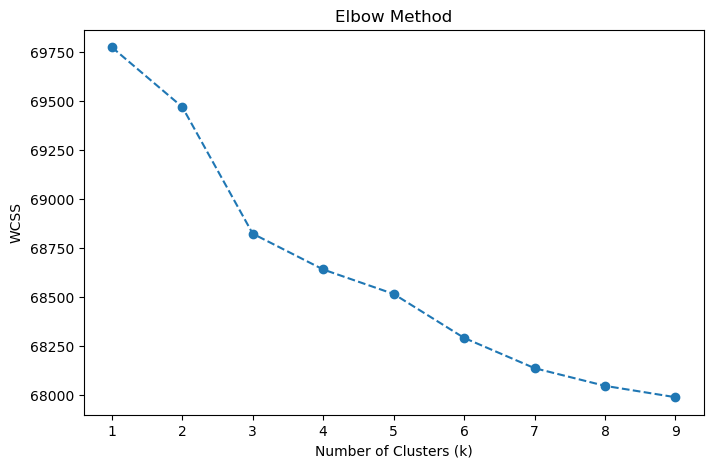

In [6]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Compute WCSS for different k values
wcss = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)  # WCSS for current k

# Plot the Elbow Graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()


In [ ]:
# from gap_statistic import OptimalK

# Example data
# data = np.array([[1, 1], [2, 2], [5, 5], [8, 8], [1, 2], [5, 6]])

# Compute the optimal number of clusters using Gap Statistic
# optimal_k = OptimalK(n_jobs=-1)  # Use all available CPU cores
# n_clusters = optimal_k(data, cluster_array=np.arange(1, 10))

# print(f"Optimal number of clusters: {n_clusters}")


## Step 4: Apply Clustering (K-Means) on TF-IDF Matrix

In [7]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)
data['cluster'] = clusters
print(data)

                timestamp                                               text  \
0     2024-10-31 00:00:00  Running a business means juggling countless ad...   
1     2024-10-31 00:00:00  Liz Truss is walking in the lingering shadow o...   
2     2024-10-31 00:00:00  The UK is bracing for war as government buildi...   
3     2024-10-31 00:00:00  Marrying a second or third cousin once removed...   
4     2024-10-31 00:00:00  It's truly disgraceful how the Indian National...   
...                   ...                                                ...   
70255 2024-10-31 23:59:52  @bakerjulie: "Saranghae, I’m your resident K-P...   
70256 2024-10-31 23:59:52  Soaring to new heights with @sweeneyanthony! T...   
70257 2024-10-31 23:59:54  Hey @james20 @paul47, did you see the latest f...   
70258 2024-10-31 23:59:58  Check out the fundraiser exhibition by @joanna...   
70259 2024-10-31 23:59:59  The appointment of Rees Mogg as business secre...   

          text_id              user    

## Step 5: Evaluate Clustering Quality

In [8]:
silhouette = silhouette_score(tfidf_matrix, clusters)
print(f'Silhouette Score (TF-IDF): {silhouette}')

Silhouette Score (TF-IDF): 0.00562579413180488


In [7]:
from sklearn.decomposition import TruncatedSVD

# Use Truncated SVD for dimensionality reduction
svd = TruncatedSVD(n_components=50, random_state=42)
reduced_tfidf = svd.fit_transform(tfidf_matrix)

print(f"Reduced TF-IDF shape: {reduced_tfidf.shape}")

Reduced TF-IDF shape: (70260, 50)


## Step 7: Re-cluster on Reduced Features

In [8]:
kmeans_reduced = KMeans(n_clusters=num_clusters, random_state=42)
clusters_reduced = kmeans_reduced.fit_predict(reduced_tfidf)
data['reduced_cluster'] = clusters_reduced

## Step 8: Evaluate Clustering Quality on Reduced Features

In [9]:
silhouette_reduced = silhouette_score(reduced_tfidf, clusters_reduced)
print(f'Silhouette Score (Reduced Features): {silhouette_reduced}')

Silhouette Score (Reduced Features): 0.12902778137247767


## Step 9: Sentiment Analysis

In [16]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

data['sentiment'] = data['text'].apply(analyze_sentiment)
print(data["sentiment"])

0        0.366667
1       -0.200000
2        0.000000
3        0.166667
4       -0.750000
           ...   
70255    0.608333
70256    0.290152
70257    0.125000
70258   -0.125000
70259   -0.400000
Name: sentiment, Length: 70260, dtype: float64


## Step 10: Visualize Clusters and Sentiments

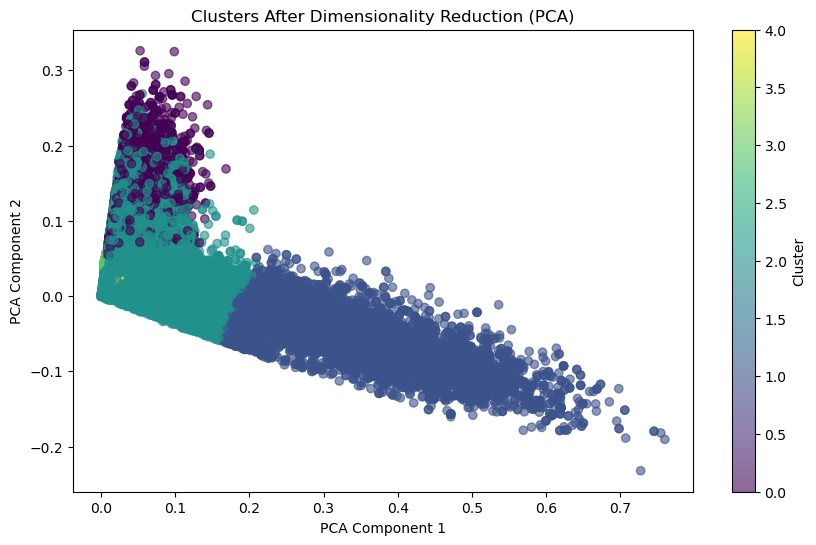

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1], c=clusters_reduced, cmap='viridis', alpha=0.6)
plt.colorbar(label='Cluster')
plt.title('Clusters After Dimensionality Reduction (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## Step 11: Generate Word Clusters

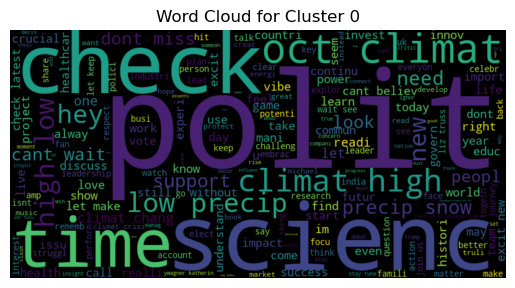

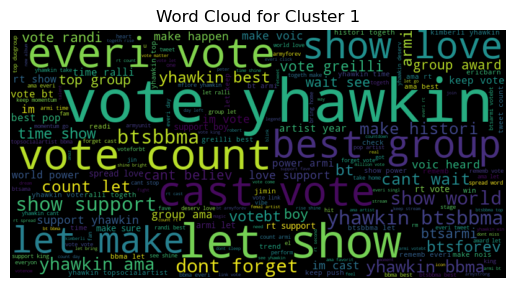

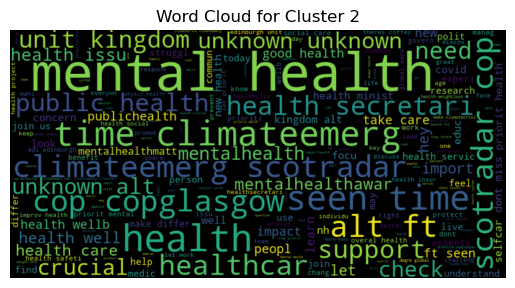

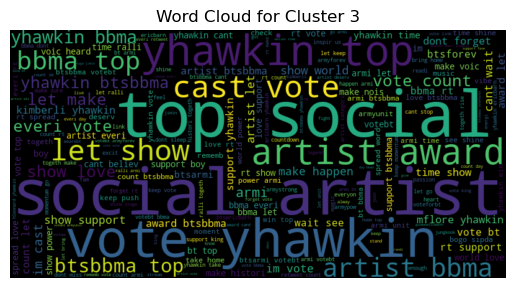

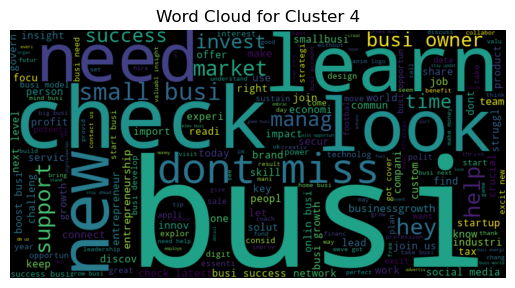

In [12]:
for cluster in range(num_clusters):
    cluster_text = data[data['cluster'] == cluster]['processed_text']
    wordcloud = WordCloud(width=800, height=400).generate(' '.join(cluster_text))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

## Step 12: Save Results

In [13]:
data.to_csv('clustered_dataset.csv', index=False)
print('Results saved to clustered_dataset.csv')

Results saved to clustered_dataset.csv
